<a href="https://colab.research.google.com/github/diro5t/deep_quadric_learning/blob/main/TorchQuadMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(C) Dirk Roeckmann 2023

Simple PyTorch MNIST classifier model with quadric layers: 784X64, 128x32, 64x10 which demonstrates the same accuracy as a linear model with layers 784X128, 128x64, 64x10 (see TorchLinQuadMNIST.ipynb)

This just by just slashing the numbers of units per layer in half!

Quadric Layers are factually able to reduce model sizes in a drastical fashion in all kinds of applications like GAN, Transformers, LLM on a very high level without even starting to think about pruning, sparse layers, quantization, architecture evolution strategies etc. etc.

The approach of quadric learning is explained here:

https://github.com/diro5t/deep_quadric_learning

and is based on my research:

https://scholar.google.com/citations?hl=en&user=hamuGh4AAAAJ

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
from torch.nn.parameter import Parameter, UninitializedParameter

import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
transf = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),])

In [ ]:
batch_size = 64

train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transf)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transf)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
img_iter = iter(train_loader)
images, labels = next(img_iter)

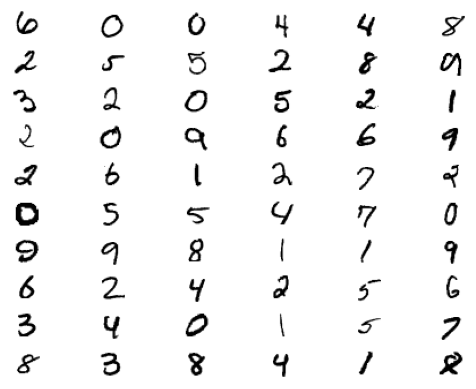

In [ ]:
figure = plt.figure()
img_num = 60
for index in range(1, img_num + 1):
    plt.subplot(10, 6, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Cutom Quadric PyTorch Layer
class Quadric(nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    qweight: Tensor
    lweight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # quadratic weights
        self.qweight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # linear weights
        self.lweight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        # bias
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.qweight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.lweight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in_q, _ = nn.init._calculate_fan_in_and_fan_out(self.qweight)
            fan_in_l, _ = nn.init._calculate_fan_in_and_fan_out(self.lweight)
            bound = 1 / math.sqrt(fan_in_l) if fan_in_l > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        input_sqr = torch.mul(input, input)
        qi = nn.functional.linear(input, self.qweight, None)
        wib = nn.functional.linear(input, self.lweight, self.bias)
        return torch.add(qi, wib)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [ ]:
model = nn.Sequential(Quadric(784, 64),
                      nn.ReLU(),
                      Quadric(64, 32),
                      nn.ReLU(),
                      Quadric(32, 10),
                      nn.LogSoftmax(dim=1))

In [ ]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
epochs = 15
for e in range(epochs):
    train_loss = 0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, train_loss/len(train_loader)))

Epoch 0 - Training loss: 0.4717849750858126
Epoch 1 - Training loss: 0.20853296546603062
Epoch 2 - Training loss: 0.15579169682626212
Epoch 3 - Training loss: 0.12831817256080222
Epoch 4 - Training loss: 0.1114167330810415
Epoch 5 - Training loss: 0.10007089066223851
Epoch 6 - Training loss: 0.08893027667379154
Epoch 7 - Training loss: 0.07857781772696372
Epoch 8 - Training loss: 0.07231285672601082
Epoch 9 - Training loss: 0.0656232239014761
Epoch 10 - Training loss: 0.061468558904748644
Epoch 11 - Training loss: 0.05717933607220189
Epoch 12 - Training loss: 0.05379059794830528
Epoch 13 - Training loss: 0.0500673756112845
Epoch 14 - Training loss: 0.04826720653455267


In [ ]:
corrects, all = 0, 0
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.inference_mode():
        logps = model(img)
    ps = torch.exp(logps)
    prob = list(ps.numpy()[0])
    inf_label = prob.index(max(prob))
    true_label = labels.numpy()[i]
    if(true_label == inf_label):
      corrects += 1
    all += 1

print("Number of tested images=", all)
print("\nModel Accuracy =", (corrects / all))

Number of tested images= 10000

Model Accuracy = 0.975
